# Imports

In [1]:
pip install -q scikit-learn qbraid qiskit-ibm-runtime qiskit-aer qiskit-aer-gpu qiskit-ionq amazon-braket-sdk qiskit-braket-provider qiskit-rigetti

  DEPRECATION: Building 'rpcq' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rpcq'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'antlr4_python3_runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4_python3_runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take int

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import scipy.io
from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import random

from qiskit import QuantumCircuit, qasm3
import qiskit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_aer import AerSimulator
import qiskit_ionq
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import StatePreparation
# from qiskit_braket_provider import BraketProvider, AWSBraketProvider
# from qiskit_rigetti import RigettiQCSProvider
from qiskit_braket_provider.providers.adapter import convert_qiskit_to_braket_circuit
from qiskit_ibm_runtime import QiskitRuntimeService,Session, SamplerV2 as Sampler

from qbraid import QbraidProvider
from qbraid.transpiler import transpile, Conversion, ConversionGraph
from qbraid.programs import load_program
from qbraid.transpiler.conversions.qiskit import qiskit_to_ionq
from qbraid.runtime.ibm import QiskitRuntimeProvider

from joblib import Parallel, delayed
import multiprocessing
import subprocess
import itertools as it

qbraid_provider = QbraidProvider(api_key="3o49jgmbqgyo8y92nur1jm1x2lb7d9")
qbraid_provider.save_config()

ibm_provider = QiskitRuntimeProvider('ywS3ujtyOXHu-CYJC_lqa6jgNATxEUxOnHoK3acCSDIc',
                                 'crn:v1:bluemix:public:quantum-computing:us-east:a/dac002c4157545e1a096dc4a15bf33f2:c6bc0367-a161-405c-930d-155e13bbf20e::',
                                channel = 'ibm_cloud');

In [3]:
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

cpus = multiprocessing.cpu_count()
print("Cpus = ", cpus)

No Nvidia GPU in system!
Cpus =  96


In [4]:
import platform
platform.platform()

'Linux-6.1.141-x86_64-with-glibc2.35'

# Data Load

In [5]:
def load_data(file, plane = -1,):
    """
    Planes -> [0,4] for specific plane, else all data
    """
    mat = scipy.io.loadmat(file)
    
    ext = lambda var : [i[0] for i in mat[var][1:6]];
    cnct = lambda d: np.concatenate(d);
    
    Data = ext('zDFF');
    X = ext('allxc')
    Y = ext('allyc')
    Z = ext('allzc')
    
    if plane >= 0 and plane <= 4 :
        return (X[plane], Y[plane], Z[plane], Data[plane])
    else:
        return (cnct(X), cnct(Y), cnct(Z), cnct(Data));

In [6]:
def preprocess_spike_data(raw_data, clip_neg=True, scale=True):
    """
    Clip negatives and/or min-max scale each neuron's time-series.
    """
    data = np.maximum(raw_data, 0.0) if clip_neg else raw_data.copy()
    if scale:
        data = MinMaxScaler().fit_transform(data)
    return data


# Quantum System

In [7]:
def get_device(provider = 'ionq'):
    default = 'ionq_simulator';
    if provider == 'rigetti':
        default = 'rigetti_ankaa_3';
    if provider == 'ibm':
        return ibm_provider.least_busy();
    return qbraid_provider.get_device(default);

def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    num_multi_qubit_ops = sum(1 for instr, qargs, _ in qc.data if len(qargs) > 1)
    return depth, num_qubits, num_multi_qubit_ops
    # return {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num"_multi_qubit_ops} 

def print_qc_characteristics(circuits):
    circuits_details = [get_qc_characteristics(c) for c in circuits];
    characteristics = {"depth":np.average([x[0] for x in circuits_details]),
          "num_qubits":np.average([x[1] for x in circuits_details]),
          "num_multi_qubit_ops": np.average([x[2] for x in circuits_details])} 
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])

def ionq_circuit(qc):
    qiskit_provider = qiskit_ionq.IonQProvider()
    backend = qiskit_provider.get_backend("simulator", gateset="native")
    circuit = qiskit.transpile(qc, basis_gates=backend.configuration().basis_gates)   
    circuit.data = filter(lambda x: x.operation.name != 'reset', circuit.data)
    ionq_dict = qiskit_to_ionq(circuit, gateset="native")
    program = load_program(ionq_dict)
    return program.serialize(), circuit;


def rigetti_circuit(qc):
    """
        #TODO: NOt working as depth is too high after transpilation
        May be write code directly in braket for the circuit instead of qiskit
    """
    # basis_gate = ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z'];
    # ['rx', 'rz', 'iswap']
    # circuit = qiskit.transpile(qc, basis_gates=basis_gate)  
    # print("AB:" ,circuit.depth(), circuit.count_ops());
    # circuit.data = filter(lambda x: x.operation.name != 'reset', circuit.data)
    # print("Here:" ,circuit.depth(),circuit.count_ops());
    cir = transpile(qc, "braket");
    # print("There:" , type(cir), cir.depth);
    return cir;

def ibm_circuit(qc, id):
    pass_manager = generate_preset_pass_manager(
        optimization_level=1, 
        backend= ibm_provider.runtime_service.backend(id))
    return qc, pass_manager.run(qc);

def run_circuits(circuits, provider, shots):
    """
        submit all jobs in one batch
    """
    device = get_device(provider);
    if provider == 'rigetti':
        cirq = rigetti_circuit;
    elif provider == 'ibm':
       cirq = lambda c: ibm_circuit(c, device.id);
    else: 
        cirq = ionq_circuit;

    # Not working for rigetti
    print_qc_characteristics([cirq(c)[1] for c in circuits]);
    
    if provider == 'ionq':
        jobs = [device.submit(cirq(c)[0], shots = shots, noise_model = 'aria-1')
                       for c in circuits];
    elif provider == 'ibm':
        jobs = [device.run(cirq(c)[0], shots = shots) for c in circuits];
    return jobs;

def get_job_results(job):
    res = job.result()
    # print(res)
    prob = res.data.get_probabilities();
    if "ibm" in res.device_id:
        time = job._job.usage();
    elif "ionq" in res.device_id: 
        time = job.metadata()['time_stamps']['executionDuration']//1000;
    return prob, time;   

# Distance matrices

In [8]:
# ============================================================
# 2.  CLASSICAL  KERNEL-PCA  DISTANCE  EVALUATOR
# ============================================================
def classical_kernel_distance(data, isKernelPCA, **kernel_kw):
    """
    (a) Kernel-PCA → low-dim features
    (b) metirc => Correlation or Euclidean distances on the reduced space
    Returns square distance matrix.
    """
    if isKernelPCA == True:
        kpca = KernelPCA(n_components=kernel_kw['n_components_pca'], kernel=kernel_kw['kernel_pca'], n_jobs = -1)
        X_red = kpca.fit_transform(data)
    return pairwise_distances(X_red if isKernelPCA == True else data, metric=kernel_kw['metric'], n_jobs = -1)

In [9]:
# ============================================================
# 3.  QUANTUM  CIRCUIT  &  KERNEL  EVALUATOR
# ============================================================
# -- 3.1  Encoding / ansatz ----------------------------------
def amplitude_encode(vec):
    L = 1 << int(np.ceil(np.log2(len(vec))))
    padded = np.zeros(L)
    padded[:len(vec)] = vec
    normed = padded / np.linalg.norm(padded)
    qc = QuantumCircuit(int(np.log2(L)))
    qc.initialize(normed, qc.qubits)
    return qc

def cz_ring_ansatz(qc, depth=1, ry_angle=np.pi/4):
    n = qc.num_qubits
    for _ in range(depth):
        for i in range(n-1):
            qc.cz(i, i+1)
        qc.cz(n-1, 0)
        for i in range(n):
            qc.ry(ry_angle, i)
    return qc

def build_neuron_circuit(ts, isHardware = False, ansatz_fn=cz_ring_ansatz, **ansatz_kw):
    qc = amplitude_encode(ts);
    qc = ansatz_fn(qc, **ansatz_kw)
    if isHardware == True:
        qc.measure_all();
    else:
        qc.save_statevector();
    return qc;

def calculate_fidelity(p1, p2):
    def prod(x):
        return p1[x] * p2[x];
    common_states = set(p1).intersection(p2);
    if not bool(common_states):
        return 0;
    else:
        prod = np.vectorize(prod)
        return np.sum(np.sqrt(prod(np.array(list(common_states)))))**2;
            

def fidelity_to_distance(K):
    """√2(1 − F)   (valid for fidelity kernels)"""
    return np.sqrt(np.abs(2 * (1 - K)))


# -- 3.2  Quantum kernel matrix ------------------------------
def quantum_kernel_matrix_sim(circuits, device = 'CPU', metric_q="fidelity", **kw_dist):
    #TODO: GPU not working
    N = len(circuits)
    K = np.zeros((N, N))
    #def sv_c(c):
       # return Statevector.from_instruction(c)
    #sv = np.vectorize(sv_c, otypes=[object])
    #sv_cache = sv(circuits) 
    print_qc_characteristics(circuits);
    sv_cache = np.empty(N, dtype = object);
    sim_statevector = AerSimulator(method='statevector', device = device)
    job_statevector = sim_statevector.run(circuits, shots=1).result() # Shots = 1 because using the idel state_vector simulation
    for i in range(N):
        sv_cache[i] = job_statevector.get_statevector(circuits[i])
    if metric_q == "fidelity":
        return fidelity_to_distance(pairwise_distances(sv_cache, metric=state_fidelity, n_jobs=-1))
    else:
        return classical_kernel_distance([sv.probabilities() for sv in sv_cache], isKernelPCA = True,  metric=metric_q, **kw_dist)
        # pairwise_distances([sv.probabilities() for sv in sv_cache], metric=metric, n_jobs=-1)


def quantum_kernel_matrix_hardware(circuits, provider: str = 'ionq', shots = 1, metric_q="fidelity"):
    N = len(circuits)
    jobs = run_circuits(circuits, provider, shots);
    sv_cache = Parallel(n_jobs=cpus//2,backend = "threading")(delayed(get_job_results)(j) for j in jobs)
    time_jobs = np.average([x[1] for x in sv_cache]);
    st = time() 
    if metric_q == "fidelity":
        dm =  fidelity_to_distance(pairwise_distances([x[0] for x in sv_cache], metric=calculate_fidelity, n_jobs=-1))
    else:
        #TODO: Not working. Need to see how can we write code for comparing from dictionaries
        dm = pairwise_distances([sv[0].data.get_probabilities() for sv in sv_cache], metric=metric_q, n_jobs=-1)
    time_dm = time()-st;
    return time_jobs + time_dm, dm



# Clustering

In [10]:
def hierarchical_cluster(XYZ, dist_mat, isConnected_cluster = False, neighbours_cluster = 10, **kw_agg):
    """
    Compute linkage → dendrogram; returns (Z, fig, ax)
    """
    connectivity = None;
    if isConnected_cluster:
        connectivity = kneighbors_graph(XYZ, n_neighbors = neighbours_cluster, n_jobs = -1);                
    
    model = AgglomerativeClustering(connectivity = connectivity,
                                   metric = "precomputed",
                                   compute_distances = True,
                                   n_clusters = kw_agg['n_clusters'],
                                   linkage = kw_agg['linkage'],
                                   )
    model.fit(dist_mat);
    
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float);
    return linkage_matrix, model.labels_;


def plot_figures(XYZ, linkage_matrix, labels, metrics, **args_den):
    p_dendos = [5, 10, 20, 40]; #filter for dendogram display
    truncate_mode_dendos = ['level', 'lastp']; #lastp, level[f"neuron_{i}" for i in range(N)];
    
    fig, ax = plt.subplots(len(p_dendos),len(truncate_mode_dendos), figsize=(10, 20))
    
    # Dendogram
    for i in range(len(p_dendos)):
        for j in range(len(truncate_mode_dendos)):
            dendrogram(linkage_matrix, 
                               p = p_dendos[i],
                               truncate_mode = truncate_mode_dendos[j],
                               # labels = [f"neuron_{i}" for i in range(len(labels))],
                               color_threshold = args_den['color_threshold_dendo'],
                               distance_sort = 'ascending',
                               ax = ax[i,j],
                              )
            ax[i,j].set_title("Dendogram-" + str(p_dendos[i]) + "-" + truncate_mode_dendos[j])
            ax[i,j].set_ylabel(metrics.title() + " distance")

    plt.tight_layout()
    plt.show()
    
    #Scatter plot
    # TODO: Check a better 3d representation

    fig_, ax_ = plt.subplots(1,4, figsize=(10, 4))
    ax_[0].remove()
    ax_[0]=fig_.add_subplot(1,4,1,projection='3d')
    ax_[0].scatter(
        XYZ[:, 0],
        XYZ[:, 1],
        XYZ[:, 2],
        c=labels, 
        cmap=plt.cm.Set1,
        s = 30,
        edgecolor="k",
    )
    ax_[0].set_title("Clustered Data")

    label = 'XYZ'
    
    for i in range(1,4):
        ax_[i].scatter(
            XYZ[:, i-1],
            XYZ[:, (i)%3],
            c=labels, 
            cmap=plt.cm.Set1,
            s = 30,
            edgecolor="k",
        )
        ax_[i].set_title(label[i-1] + label[(i)%3] + "Projection")
        ax_[i].set_xlabel(label[i-1])
        ax_[i].set_ylabel(label[(i)%3])
    
    plt.tight_layout()
    plt.show()
    return fig, ax, fig_, ax_;


# Experiment-1

In [14]:
"""
Parameters for experiemnts
<!-- Running for: 
 ;plane_data= -1 ;isKernelPCA= True ;n_components_pca= 10 ;kernel_pca= linear ;
 metric= euclidean ;depth= 4 ;ry_angle= 0 ;metric_q= fidelity ;isConnected_cluster= True ;
 neighbours_cluster= 2 ;n_cluster= 20 ;linkage= complete -->
"""
plane_datas = [-1]; #[0,4] or -1 for all plane 
file_data: str = 'data_1.mat'; #data_1.mat, data_2.mat

clip_neg_data: bool = True; # if clip negative features
scale_data: bool = True; # if if scale features

isKernelPCAs = [True];
n_components_pcas = [10];
kernel_pcas = ['linear']; #rbf, linear, poly, sigmoid, cosine, 
metrics = ['euclidean']; #correlation, euclidean, cosine, . For classical kernel

isHardware_run: bool = False; 
Hardware = 'ionq';
depths = [4]; #circuit depth
ry_angles = [0];
metric_qs = ['fidelity']; # fidelity, others as metric . For quantum kernel

isConnected_clusters = [True]; # Whether spatial connection info used while clustering
neighbours_clusters = [2]; # neighbours used to define local conectivity
n_clusters = [ 20];
linkages = ['complete']; # single, complete, average

color_threshold_dendo = None; # float or None



In [15]:
No_of_experiments = 1
selected_parameters = random.sample(list(it.product(
                                    plane_datas,
                                    isKernelPCAs,
                                    n_components_pcas,
                                    kernel_pcas,
                                    metrics,
                                    depths,
                                    ry_angles,
                                    metric_qs,
                                    isConnected_clusters,
                                    neighbours_clusters,
                                    n_clusters,
                                    linkages,
                                    )), No_of_experiments)


Running for: 
 ;plane_data= -1 ;isKernelPCA= True ;n_components_pca= 10 ;kernel_pca= linear ;metric= euclidean ;depth= 4 ;ry_angle= 0 ;metric_q= fidelity ;isConnected_cluster= True ;neighbours_cluster= 2 ;n_cluster= 20 ;linkage= complete


/tmp/ipykernel_1061/3985082496.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  num_multi_qubit_ops = sum(1 for instr, qargs, _ in qc.data if len(qargs) > 1)


Quantum circuit characteristics
  Depth: 53.0
  Number of qubits: 12.0
  Number of multi-qubit Operations: 50.0
Time taken: Classical = 2.2660059928894043 Quanutum = 36.75975298881531


/opt/.qbraid/environments/qgss_000000/pyenv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:592: UserWarning: the number of connected components of the connectivity matrix is 11 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


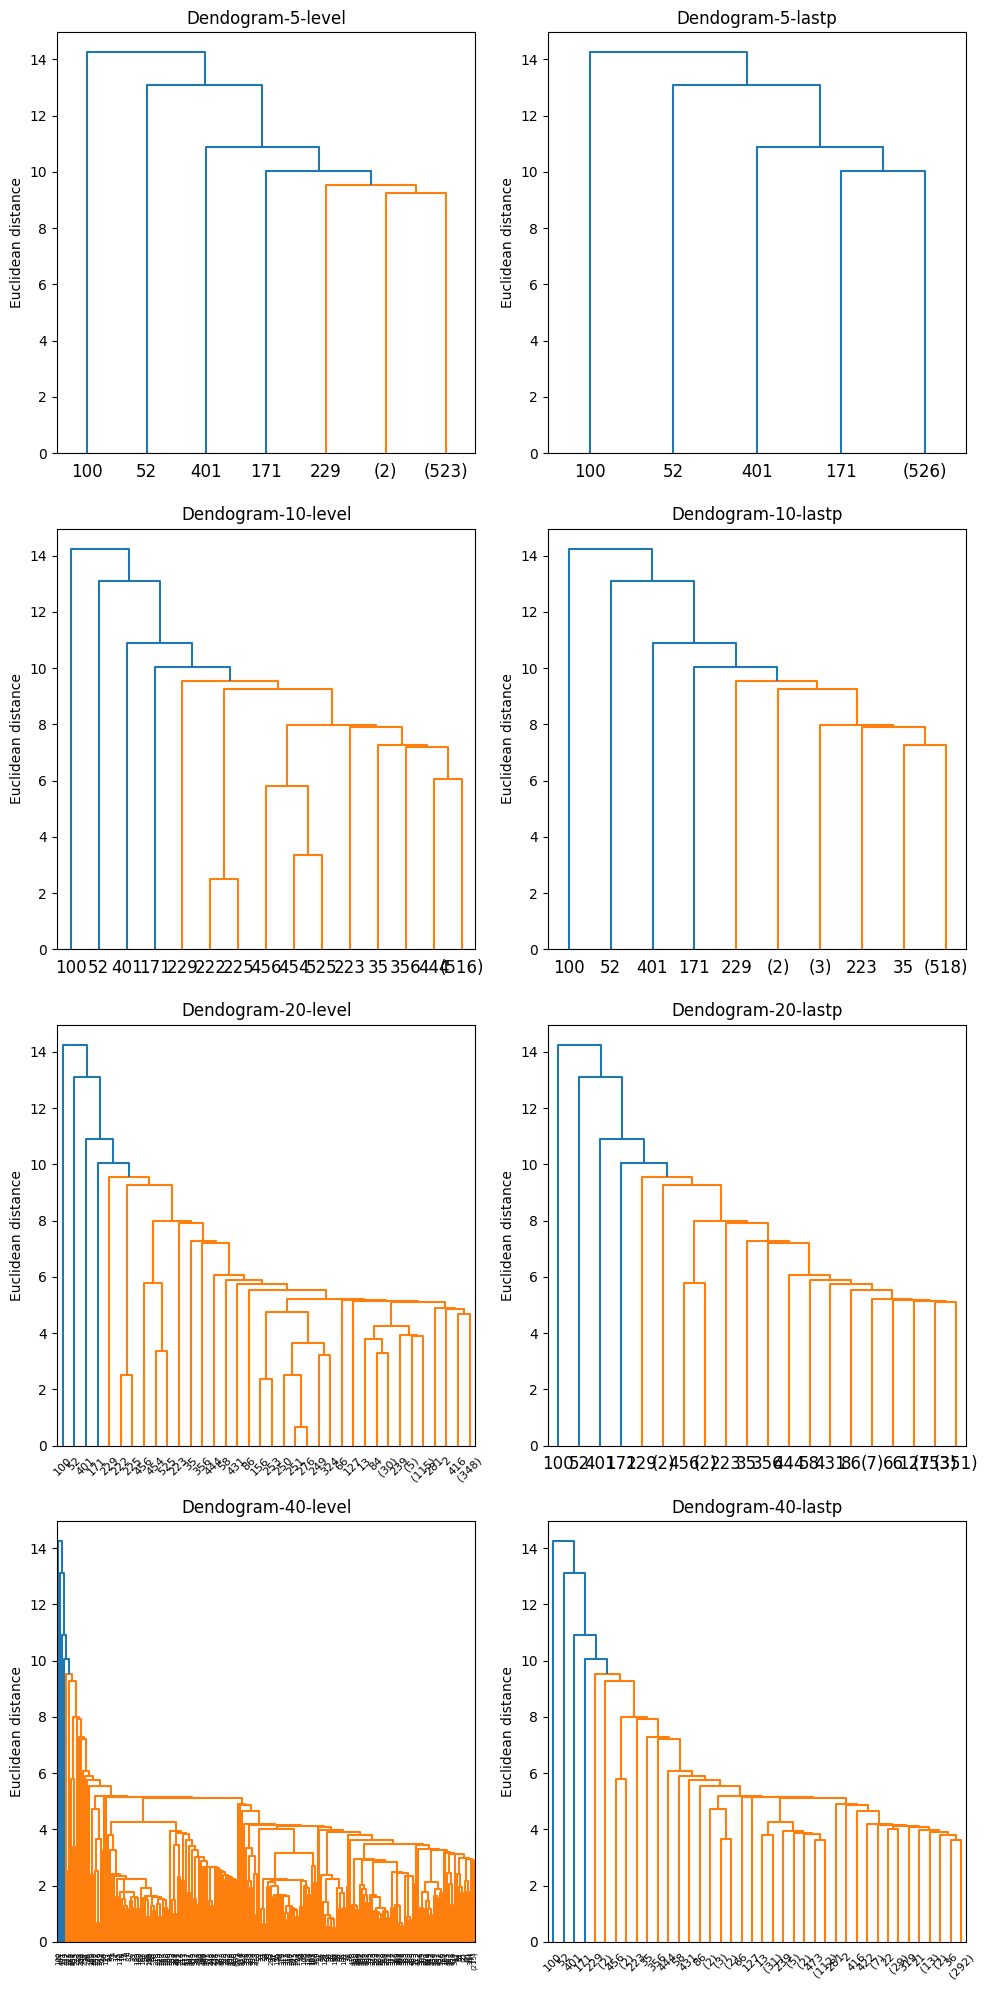

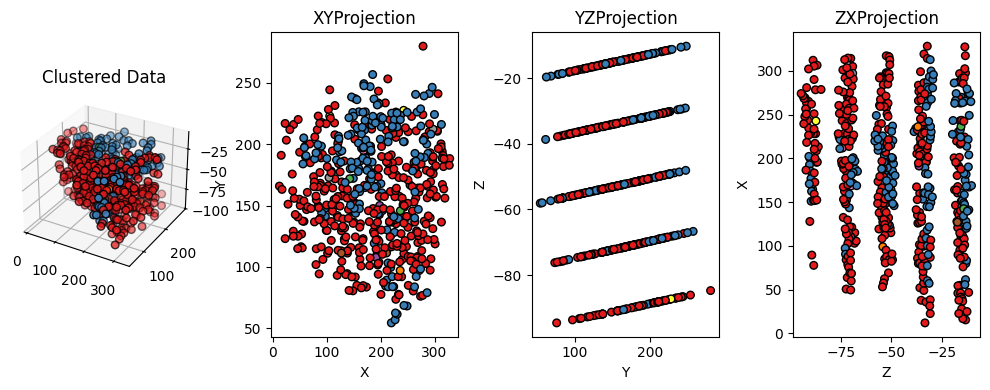

/opt/.qbraid/environments/qgss_000000/pyenv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:592: UserWarning: the number of connected components of the connectivity matrix is 11 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


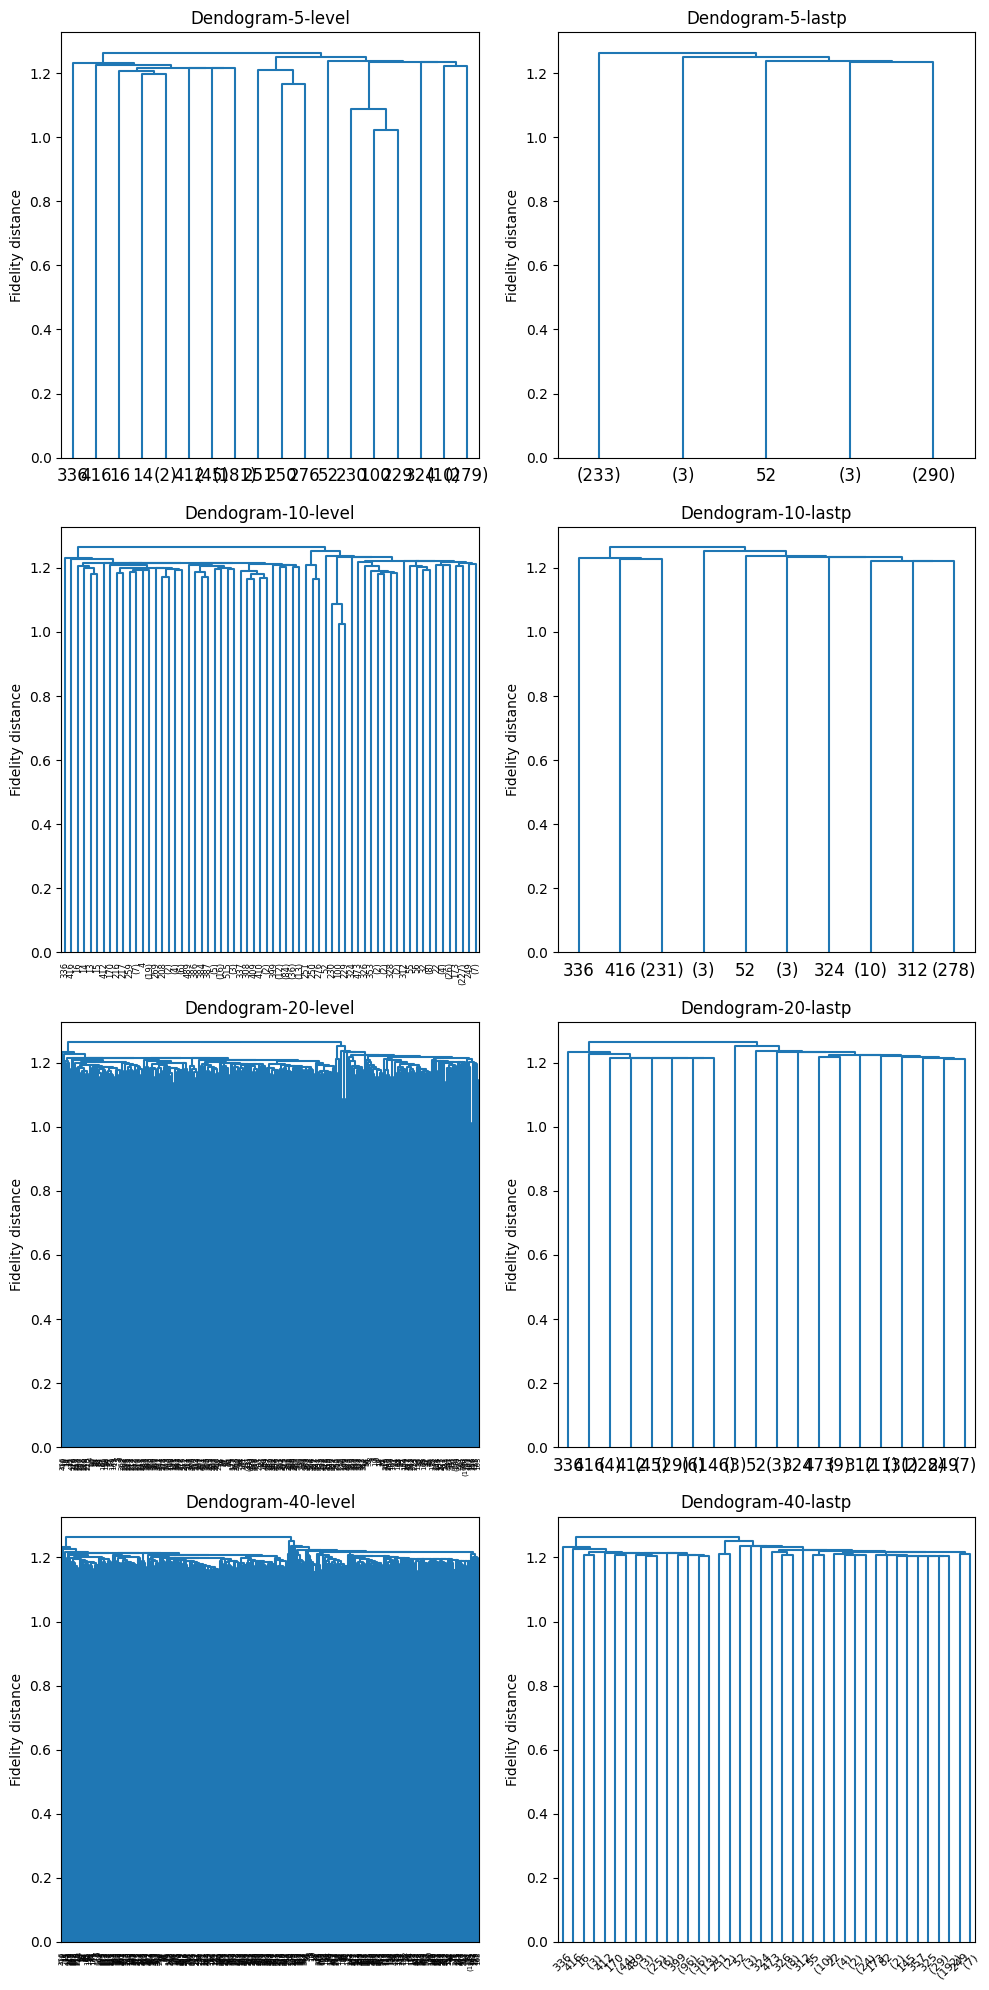

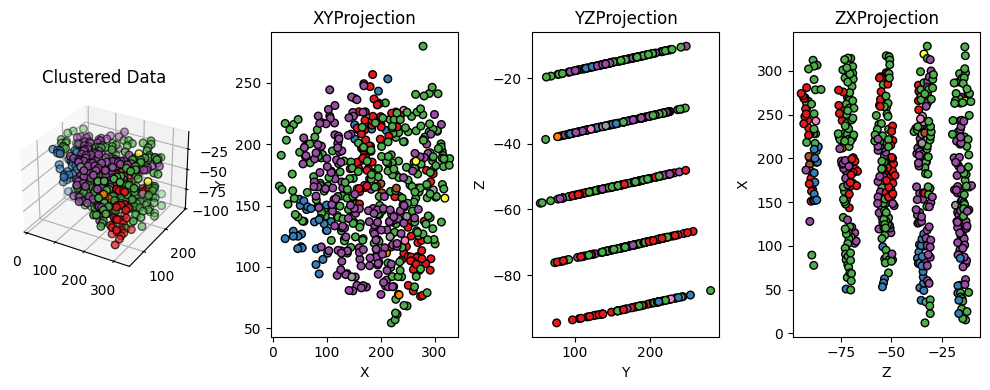

[ 0  0  0  0  4  4  4  4  0  0  0  0  0  4  4  4  4  4  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 11  4  0  0  0  0 12  0  0  0  0  0  0  0 17  0  0  4  4  0
  0  0  0  4  0  0  0  0  0  0  0  4  4  4 15  4  4  4  4  4  0  0  0  0
  0  0  0  0 16  0  4  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  4  4  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  4  0  0  0  0  0  4  0  0
  0  4  4 10  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  4  4  4  4  4  4
  4  4  4  4  4  4  2  8  4  2  4  0  0 13  0  4  4  0  4  0  4  4  4  4
  0  0  0  4  4  4  0  0  0  1  1  1  0  1  0  0  0  4  4  4  4  0  0  0
  0  0  0  0  0  4  4  4  0  0  0  0  1  0  0  0  0  0  0  0  4  0  0  4
  4  4  4  4  0  4  4  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  4  0  0  0  0  0  0  0  0  0  0  1  0  4  4  4

In [16]:
"""
Parameters for experiemnts
"""

if __name__ == "__main__":
    for par in selected_parameters:
        plane_data: int = par[0] 
        
        isKernelPCA: bool = par[1] 
        n_components_pca: int = par[2] 
        kernel_pca: str = par[3] 
        metric: str = par[4] 
       
        depth: int = par[5] 
        ry_angle: float = par[6] 
        metric_q: str = par[7]
        
        isConnected_cluster: bool = par[8] 
        neighbours_cluster: int = par[9] 
        n_cluster = par[10] 
        linkage = par[11] 

        print("Running for: \n", 
        ";plane_data=", plane_data,
        
        ";isKernelPCA=", isKernelPCA,
         ";n_components_pca=", n_components_pca,
         ";kernel_pca=", kernel_pca,
        ";metric=",  metric,
       
        ";depth=",  depth,
        ";ry_angle=",  ry_angle,
        ";metric_q=",  metric_q,
        
         ";isConnected_cluster=", isConnected_cluster,
         ";neighbours_cluster=", neighbours_cluster,
         ";n_cluster=", n_cluster,
         ";linkage=", linkage,
        )
        
        # ----- 5.1  Load data -------
        data = load_data(file_data, plane_data)
        XYZ = np.column_stack([data[0][:], data[1][:], data[2][:]]);
        cal_data = data[3][:];
        del data;
    
        
        # ----- 5.2  preprocessing --------
        X = preprocess_spike_data(cal_data, clip_neg_data, scale_data)
        del cal_data;
    
        
        # ----- 5.3  pick evaluator -------
        st = time()
        #  (A) Classical kernel-PCA distance
        dist_classical = classical_kernel_distance(
            X, isKernelPCA, n_components_pca=n_components_pca, kernel_pca=kernel_pca, metric=metric
        )
        time_classical = time()-st;
    
        #  (B) Quantum distance
        circuits = [build_neuron_circuit(x, isHardware_run, depth=depth, ry_angle = ry_angle) for x in X]
        if not isHardware_run:
            st = time()
            dist_quantum = quantum_kernel_matrix_sim(circuits, metric_q=metric_q,
                                                     n_components_pca=n_components_pca, kernel_pca=kernel_pca);
            time_quantum = time() - st;
        else:
            time_quantum, dist_quantum = quantum_kernel_matrix_hardware(circuits, provider = Hardware, metric_q=metric_q);
        del circuits, X;
    
        print("Time taken:" , "Classical =", time_classical,"Quanutum =", time_quantum, )
        
        # ----- 5.4  cluster & plot -------
        cluster_call = lambda dt : hierarchical_cluster(
            XYZ, 
            dt,
            isConnected_cluster,
            neighbours_cluster,
            linkage = linkage,
            n_clusters = n_cluster,
        );
    
        fig_call = lambda lk, lb, mt: plot_figures(XYZ, lk, lb, mt, color_threshold_dendo = color_threshold_dendo)
        
        linkage_classical , label_classical = cluster_call(dist_classical);
        fig_call( linkage_classical, label_classical, metric )
                     
        linkage_quantum , label_quantum = cluster_call(dist_quantum);
        fig_call( linkage_quantum, label_quantum, metric_q )

        print(label_classical, label_quantum)
        print('=' * 200);

# Experiment-2

In [17]:
"""
Parameters for experiemnts
Running for: 
 ;plane_data= -1 ;isKernelPCA= False ;n_components_pca= 320 ;kernel_pca= rbf ;metric= euclidean 
 ;depth= 2 ;ry_angle= 0 ;metric_q= fidelity ;isConnected_cluster= True ;
 neighbours_cluster= 5 ;n_cluster= 2 ;linkage= complete

"""
plane_datas = [-1]; #[0,4] or -1 for all plane 
file_data: str = 'data_1.mat'; #data_1.mat, data_2.mat

clip_neg_data: bool = True; # if clip negative features
scale_data: bool = True; # if if scale features

isKernelPCAs = [False];
n_components_pcas = [320];
kernel_pcas = ['rbf']; #rbf, linear, poly, sigmoid, cosine, 
metrics = ['euclidean']; #correlation, euclidean, cosine, . For classical kernel

isHardware_run: bool = False; 
Hardware = 'ionq';
depths = [2]; #circuit depth
ry_angles = [0];
metric_qs = ['fidelity']; # fidelity, others as metric . For quantum kernel

isConnected_clusters = [True]; # Whether spatial connection info used while clustering
neighbours_clusters = [5]; # neighbours used to define local conectivity
n_clusters = [2];
linkages = ['complete']; # single, complete, average

color_threshold_dendo = None; # float or None



In [18]:
No_of_experiments = 1
selected_parameters = random.sample(list(it.product(
                                    plane_datas,
                                    isKernelPCAs,
                                    n_components_pcas,
                                    kernel_pcas,
                                    metrics,
                                    depths,
                                    ry_angles,
                                    metric_qs,
                                    isConnected_clusters,
                                    neighbours_clusters,
                                    n_clusters,
                                    linkages,
                                    )), No_of_experiments)


Running for: 
 ;plane_data= -1 ;isKernelPCA= False ;n_components_pca= 320 ;kernel_pca= rbf ;metric= euclidean ;depth= 2 ;ry_angle= 0 ;metric_q= fidelity ;isConnected_cluster= True ;neighbours_cluster= 5 ;n_cluster= 2 ;linkage= complete


/tmp/ipykernel_1061/3985082496.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  num_multi_qubit_ops = sum(1 for instr, qargs, _ in qc.data if len(qargs) > 1)


Quantum circuit characteristics
  Depth: 27.0
  Number of qubits: 12.0
  Number of multi-qubit Operations: 26.0
Time taken: Classical = 0.355130672454834 Quanutum = 35.809290409088135


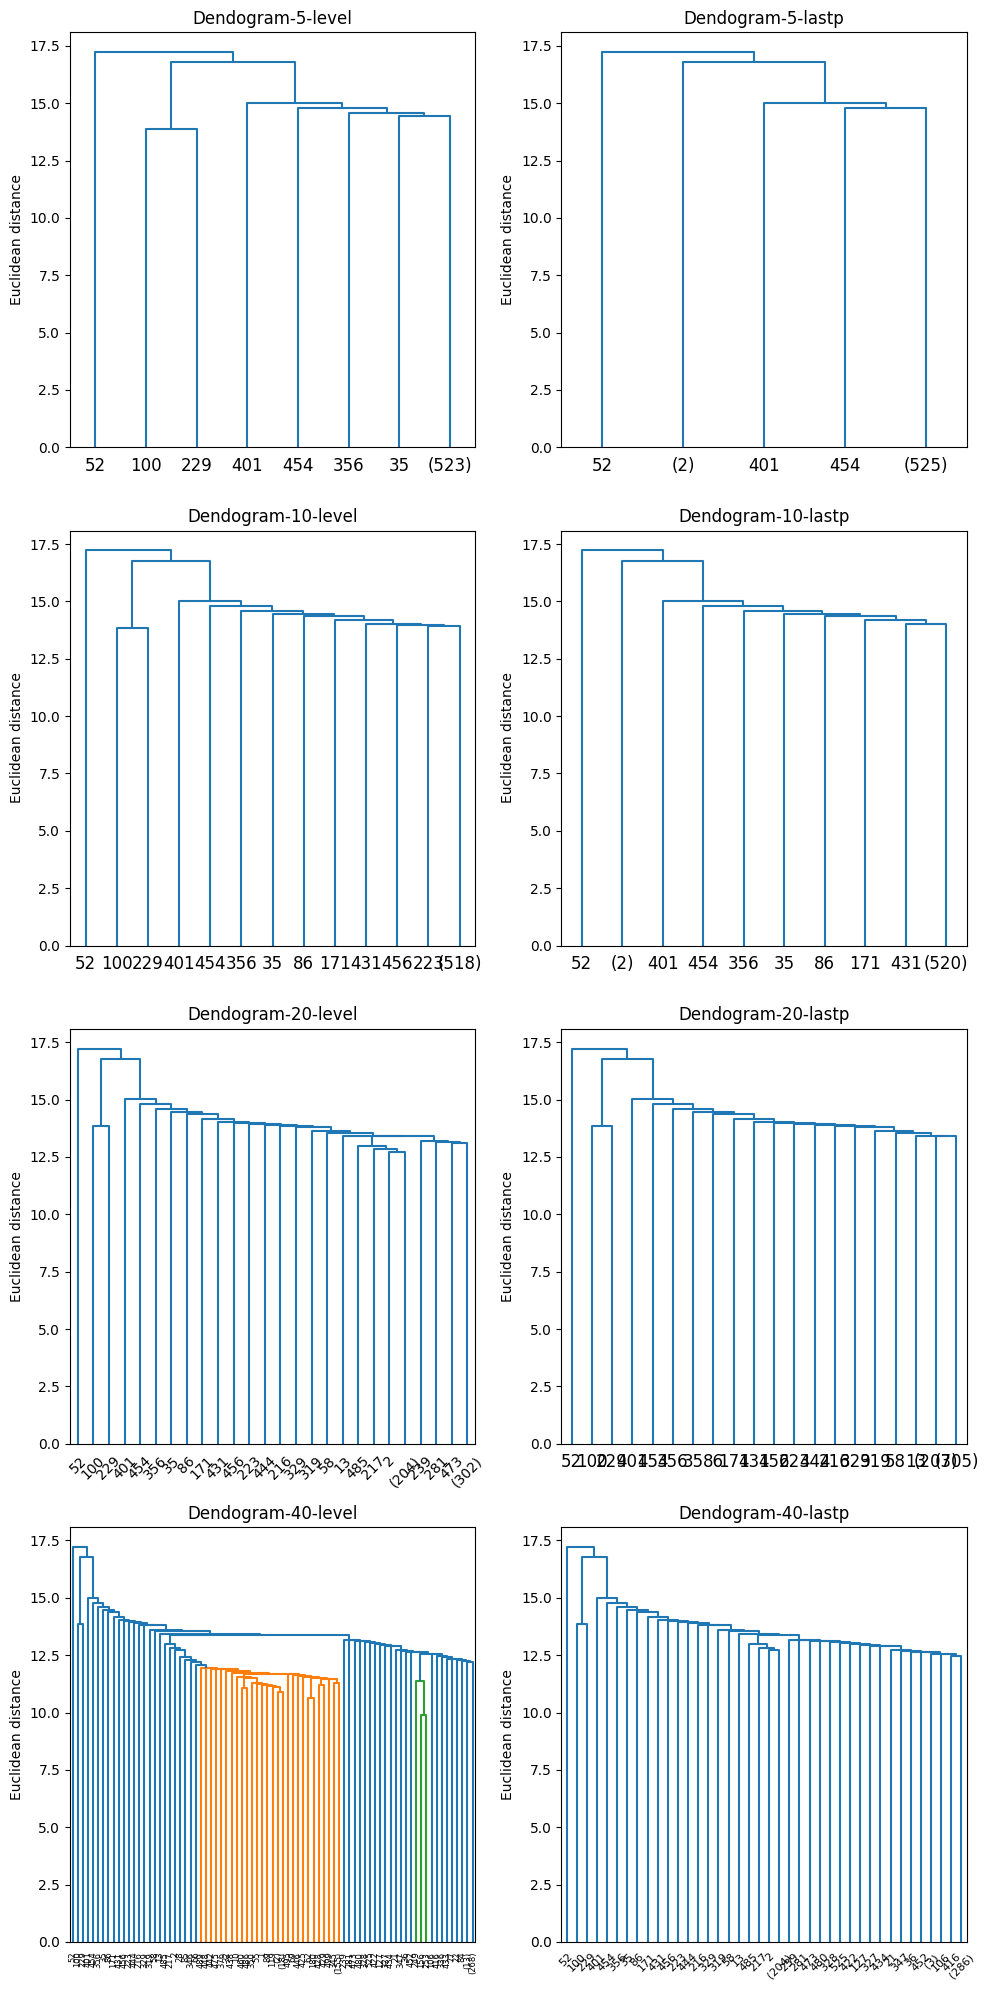

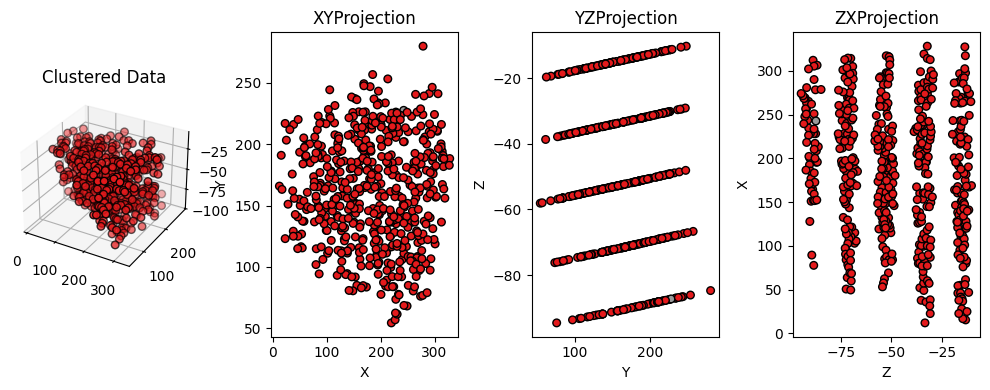

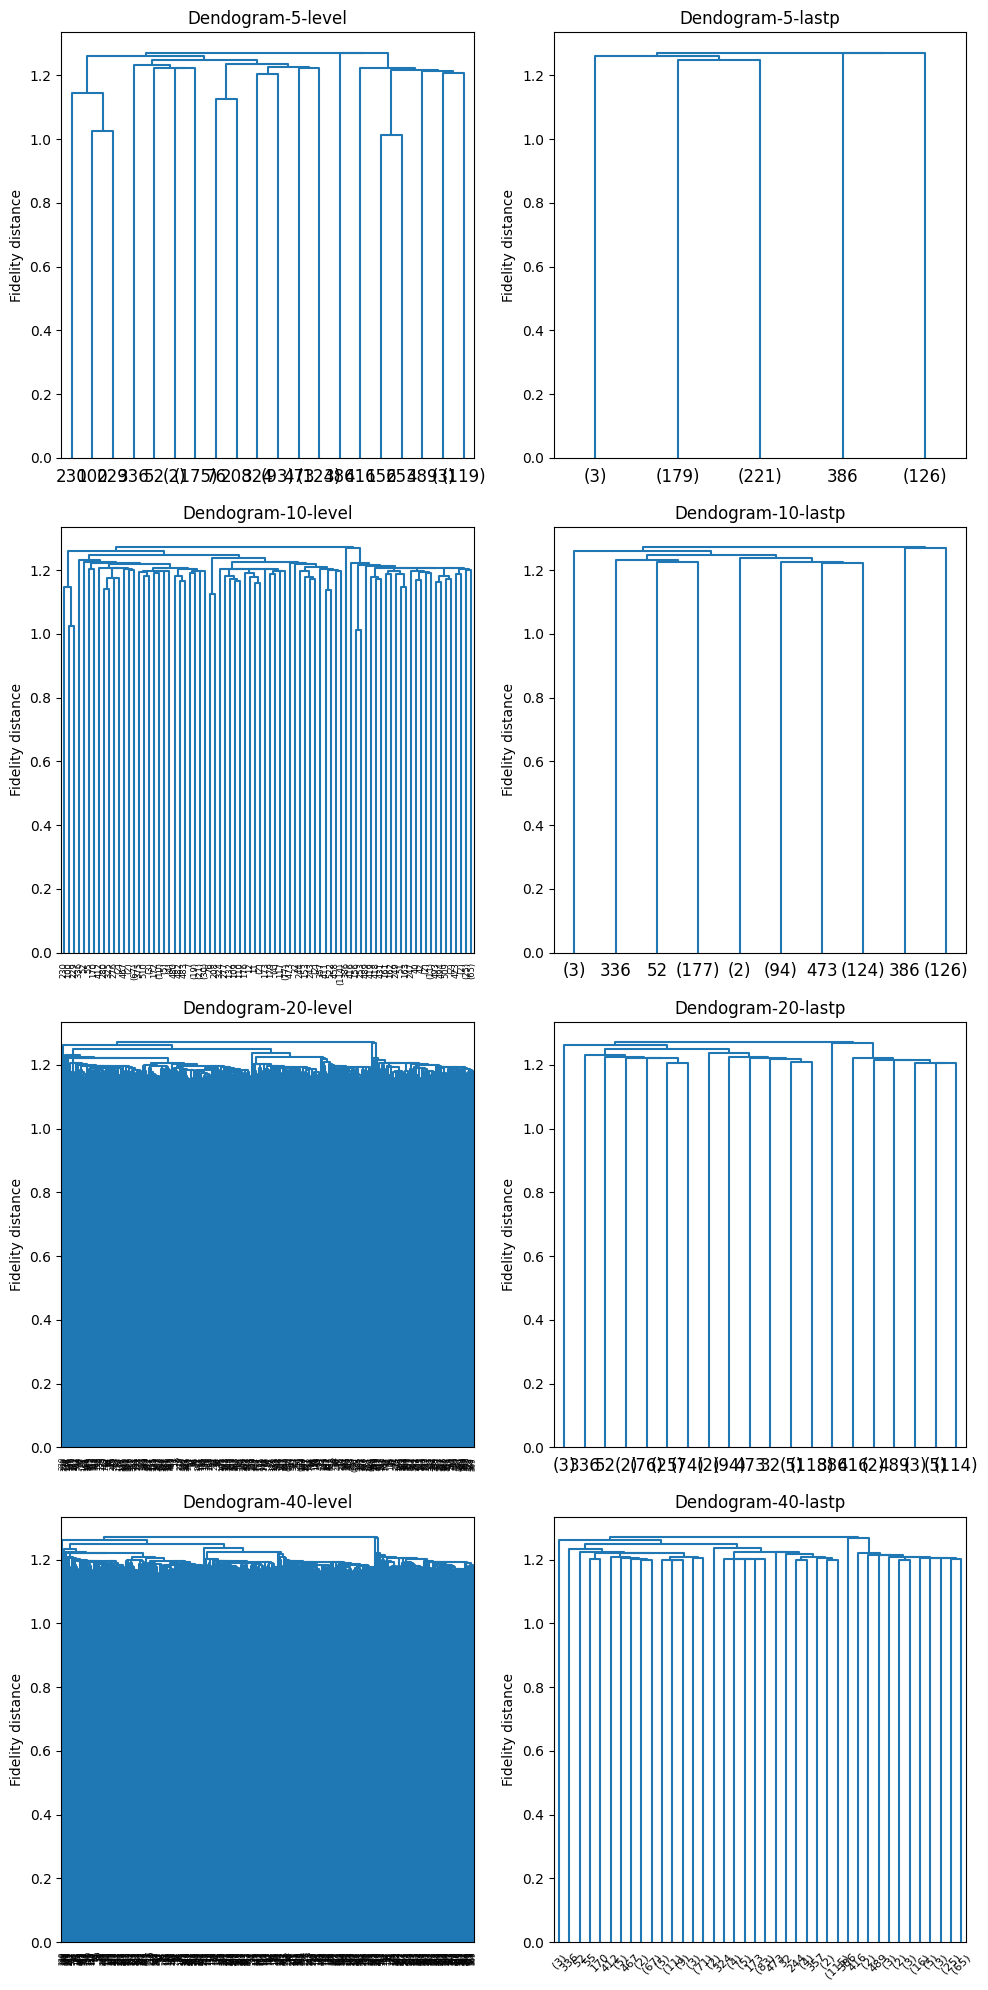

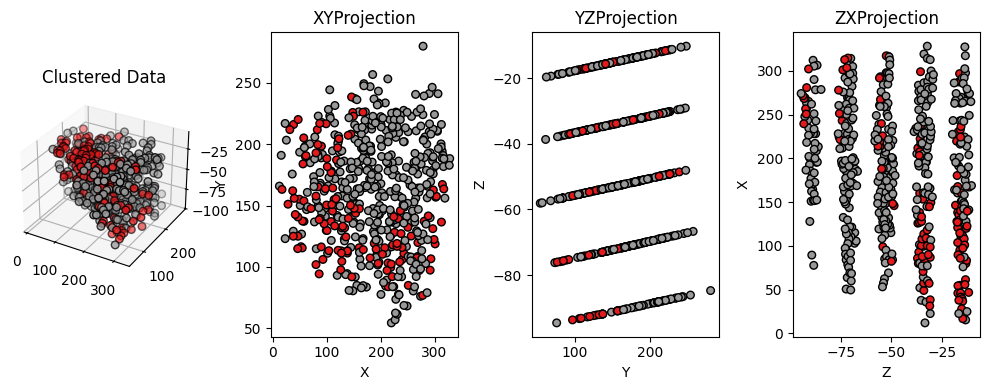

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [19]:
"""
Parameters for experiemnts
"""

if __name__ == "__main__":
    for par in selected_parameters:
        plane_data: int = par[0] 
        
        isKernelPCA: bool = par[1] 
        n_components_pca: int = par[2] 
        kernel_pca: str = par[3] 
        metric: str = par[4] 
       
        depth: int = par[5] 
        ry_angle: float = par[6] 
        metric_q: str = par[7]
        
        isConnected_cluster: bool = par[8] 
        neighbours_cluster: int = par[9] 
        n_cluster = par[10] 
        linkage = par[11] 

        print("Running for: \n", 
        ";plane_data=", plane_data,
        
        ";isKernelPCA=", isKernelPCA,
         ";n_components_pca=", n_components_pca,
         ";kernel_pca=", kernel_pca,
        ";metric=",  metric,
       
        ";depth=",  depth,
        ";ry_angle=",  ry_angle,
        ";metric_q=",  metric_q,
        
         ";isConnected_cluster=", isConnected_cluster,
         ";neighbours_cluster=", neighbours_cluster,
         ";n_cluster=", n_cluster,
         ";linkage=", linkage,
        )
        
        # ----- 5.1  Load data -------
        data = load_data(file_data, plane_data)
        XYZ = np.column_stack([data[0][:], data[1][:], data[2][:]]);
        cal_data = data[3][:];
        del data;
    
        
        # ----- 5.2  preprocessing --------
        X = preprocess_spike_data(cal_data, clip_neg_data, scale_data)
        del cal_data;
    
        
        # ----- 5.3  pick evaluator -------
        st = time()
        #  (A) Classical kernel-PCA distance
        dist_classical = classical_kernel_distance(
            X, isKernelPCA, n_components_pca=n_components_pca, kernel_pca=kernel_pca, metric=metric
        )
        time_classical = time()-st;
    
        #  (B) Quantum distance
        circuits = [build_neuron_circuit(x, isHardware_run, depth=depth, ry_angle = ry_angle) for x in X]
        if not isHardware_run:
            st = time()
            dist_quantum = quantum_kernel_matrix_sim(circuits, metric_q=metric_q,
                                                     n_components_pca=n_components_pca, kernel_pca=kernel_pca);
            time_quantum = time() - st;
        else:
            time_quantum, dist_quantum = quantum_kernel_matrix_hardware(circuits, provider = Hardware, metric_q=metric_q);
        del circuits, X;
    
        print("Time taken:" , "Classical =", time_classical,"Quanutum =", time_quantum, )
        
        # ----- 5.4  cluster & plot -------
        cluster_call = lambda dt : hierarchical_cluster(
            XYZ, 
            dt,
            isConnected_cluster,
            neighbours_cluster,
            linkage = linkage,
            n_clusters = n_cluster,
        );
    
        fig_call = lambda lk, lb, mt: plot_figures(XYZ, lk, lb, mt, color_threshold_dendo = color_threshold_dendo)
        
        linkage_classical , label_classical = cluster_call(dist_classical);
        fig_call( linkage_classical, label_classical, metric )
                     
        linkage_quantum , label_quantum = cluster_call(dist_quantum);
        fig_call( linkage_quantum, label_quantum, metric_q )

        print(label_classical, label_quantum)
        print('=' * 200);

# Experiment-3

In [20]:
"""
Parameters for experiemnts
Running for: 
 ;plane_data= 4 ;isKernelPCA= True ;n_components_pca= 160 ;
 kernel_pca= rbf ;metric= correlation ;depth= 4 ;
 ry_angle= 0.7853981633974483 ;metric_q= correlation ;
 isConnected_cluster= True ;neighbours_cluster= 10 ;n_cluster= 2 ;
 linkage= average


"""
plane_datas = [4]; #[0,4] or -1 for all plane 
file_data: str = 'data_1.mat'; #data_1.mat, data_2.mat

clip_neg_data: bool = True; # if clip negative features
scale_data: bool = True; # if if scale features

isKernelPCAs = [True];
n_components_pcas = [160];
kernel_pcas = ['rbf']; #rbf, linear, poly, sigmoid, cosine, 
metrics = ['correlation']; #correlation, euclidean, cosine, . For classical kernel

isHardware_run: bool = False; 
Hardware = 'ionq';
depths = [4]; #circuit depth
ry_angles = [0.7853981633974483];
metric_qs = ['correlation']; # fidelity, others as metric . For quantum kernel

isConnected_clusters = [True]; # Whether spatial connection info used while clustering
neighbours_clusters = [10]; # neighbours used to define local conectivity
n_clusters = [2];
linkages = ['average']; # single, complete, average

color_threshold_dendo = None; # float or None



In [21]:
No_of_experiments = 1
selected_parameters = random.sample(list(it.product(
                                    plane_datas,
                                    isKernelPCAs,
                                    n_components_pcas,
                                    kernel_pcas,
                                    metrics,
                                    depths,
                                    ry_angles,
                                    metric_qs,
                                    isConnected_clusters,
                                    neighbours_clusters,
                                    n_clusters,
                                    linkages,
                                    )), No_of_experiments)


Running for: 
 ;plane_data= 4 ;isKernelPCA= True ;n_components_pca= 160 ;kernel_pca= rbf ;metric= correlation ;depth= 4 ;ry_angle= 0.7853981633974483 ;metric_q= correlation ;isConnected_cluster= True ;neighbours_cluster= 10 ;n_cluster= 2 ;linkage= average


/tmp/ipykernel_1061/3985082496.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  num_multi_qubit_ops = sum(1 for instr, qargs, _ in qc.data if len(qargs) > 1)


Quantum circuit characteristics
  Depth: 53.0
  Number of qubits: 12.0
  Number of multi-qubit Operations: 50.0
Time taken: Classical = 0.13973355293273926 Quanutum = 0.7583374977111816


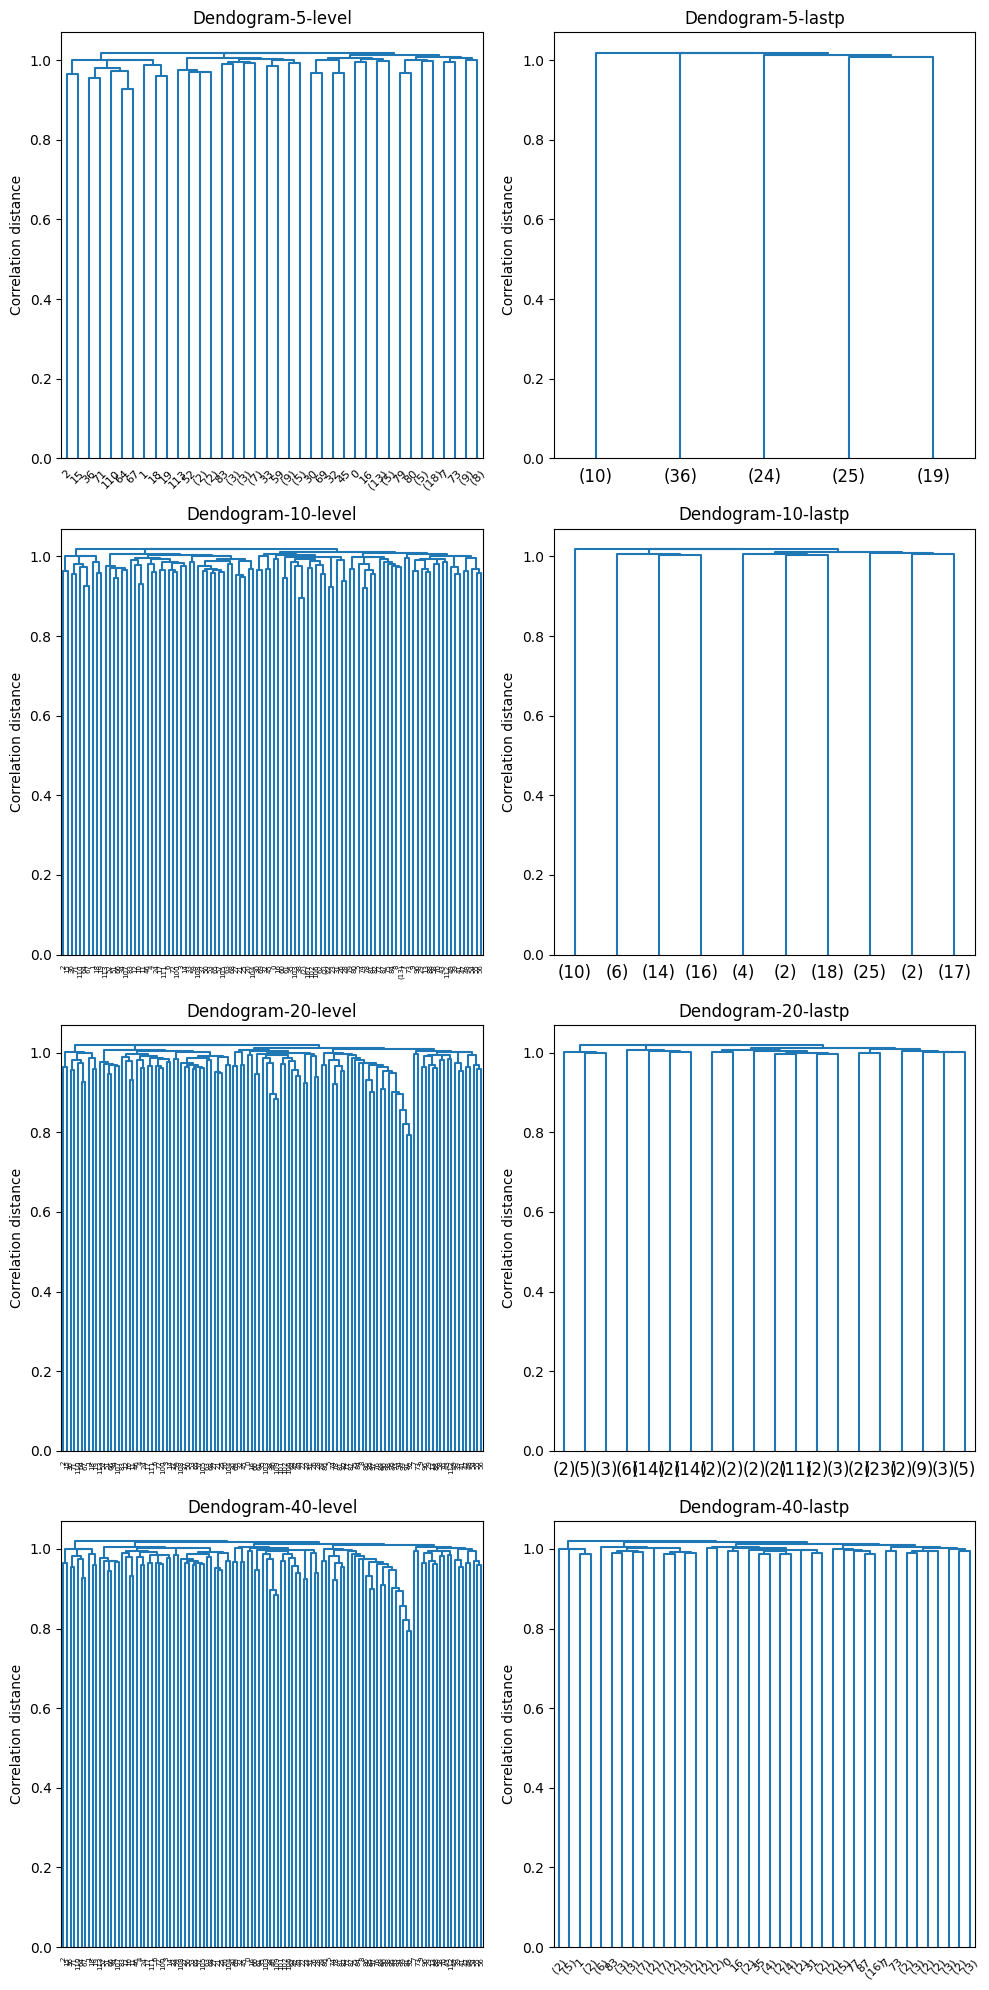

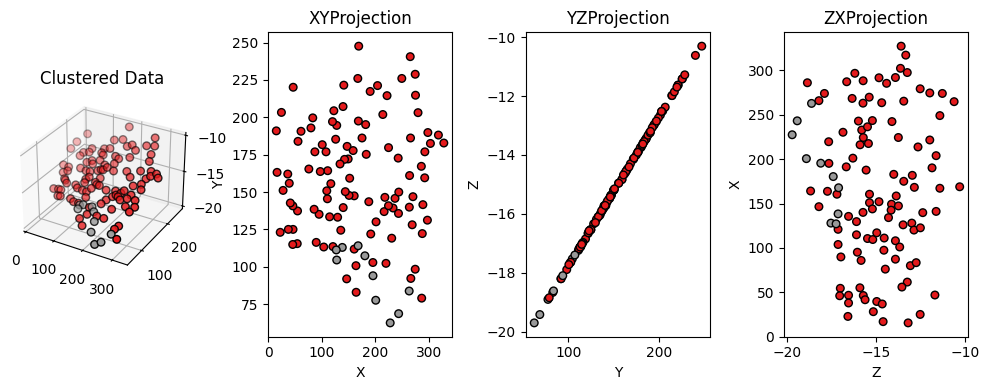

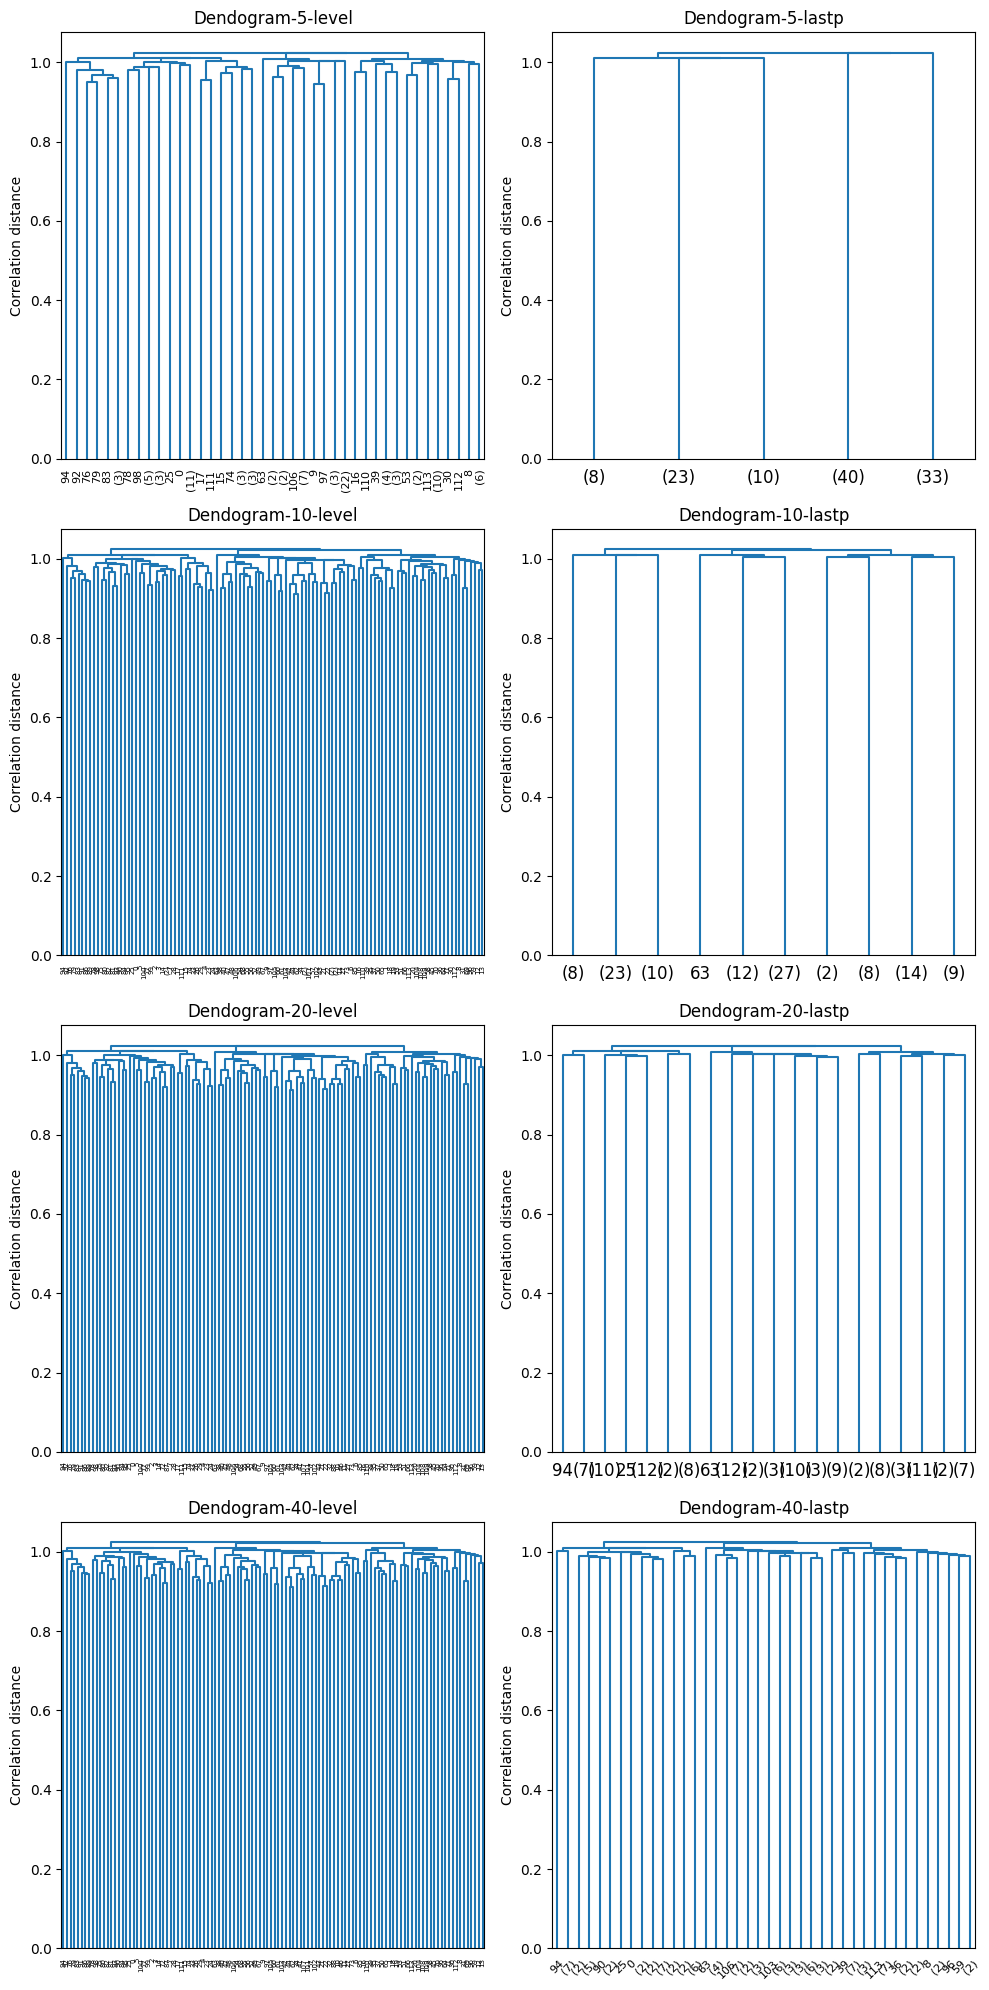

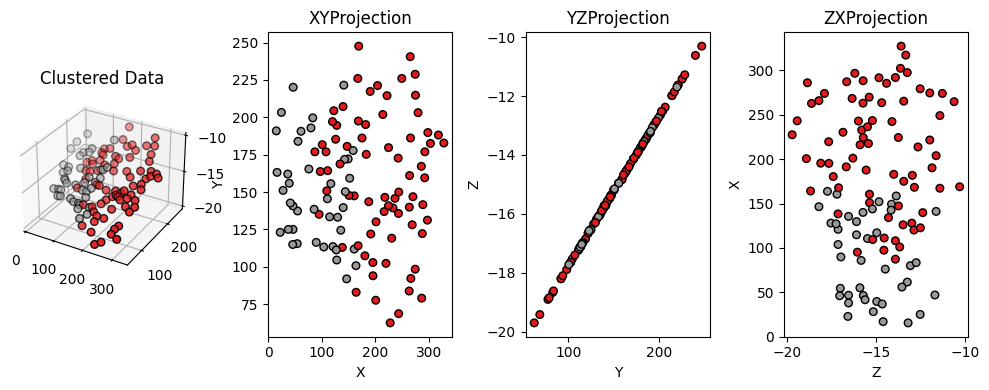

[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0] [1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0]


In [22]:
"""
Parameters for experiemnts
"""

if __name__ == "__main__":
    for par in selected_parameters:
        plane_data: int = par[0] 
        
        isKernelPCA: bool = par[1] 
        n_components_pca: int = par[2] 
        kernel_pca: str = par[3] 
        metric: str = par[4] 
       
        depth: int = par[5] 
        ry_angle: float = par[6] 
        metric_q: str = par[7]
        
        isConnected_cluster: bool = par[8] 
        neighbours_cluster: int = par[9] 
        n_cluster = par[10] 
        linkage = par[11] 

        print("Running for: \n", 
        ";plane_data=", plane_data,
        
        ";isKernelPCA=", isKernelPCA,
         ";n_components_pca=", n_components_pca,
         ";kernel_pca=", kernel_pca,
        ";metric=",  metric,
       
        ";depth=",  depth,
        ";ry_angle=",  ry_angle,
        ";metric_q=",  metric_q,
        
         ";isConnected_cluster=", isConnected_cluster,
         ";neighbours_cluster=", neighbours_cluster,
         ";n_cluster=", n_cluster,
         ";linkage=", linkage,
        )
        
        # ----- 5.1  Load data -------
        data = load_data(file_data, plane_data)
        XYZ = np.column_stack([data[0][:], data[1][:], data[2][:]]);
        cal_data = data[3][:];
        del data;
    
        
        # ----- 5.2  preprocessing --------
        X = preprocess_spike_data(cal_data, clip_neg_data, scale_data)
        del cal_data;
    
        
        # ----- 5.3  pick evaluator -------
        st = time()
        #  (A) Classical kernel-PCA distance
        dist_classical = classical_kernel_distance(
            X, isKernelPCA, n_components_pca=n_components_pca, kernel_pca=kernel_pca, metric=metric
        )
        time_classical = time()-st;
    
        #  (B) Quantum distance
        circuits = [build_neuron_circuit(x, isHardware_run, depth=depth, ry_angle = ry_angle) for x in X]
        if not isHardware_run:
            st = time()
            dist_quantum = quantum_kernel_matrix_sim(circuits, metric_q=metric_q,
                                                     n_components_pca=n_components_pca, kernel_pca=kernel_pca);
            time_quantum = time() - st;
        else:
            time_quantum, dist_quantum = quantum_kernel_matrix_hardware(circuits, provider = Hardware, metric_q=metric_q);
        del circuits, X;
    
        print("Time taken:" , "Classical =", time_classical,"Quanutum =", time_quantum, )
        
        # ----- 5.4  cluster & plot -------
        cluster_call = lambda dt : hierarchical_cluster(
            XYZ, 
            dt,
            isConnected_cluster,
            neighbours_cluster,
            linkage = linkage,
            n_clusters = n_cluster,
        );
    
        fig_call = lambda lk, lb, mt: plot_figures(XYZ, lk, lb, mt, color_threshold_dendo = color_threshold_dendo)
        
        linkage_classical , label_classical = cluster_call(dist_classical);
        fig_call( linkage_classical, label_classical, metric )
                     
        linkage_quantum , label_quantum = cluster_call(dist_quantum);
        fig_call( linkage_quantum, label_quantum, metric_q )

        print(label_classical, label_quantum)
        print('=' * 200);